In [17]:
import pandas as pd
import numpy as np
from scipy.stats import norm

# Load data from csv
df1 = pd.read_csv("bricsdailyprices.csv", parse_dates=["Date"], index_col="Date")

# Define confidence level and holding period
conf_level = 0.99
holding_period = 144 * 30  # 144 months * 30 days/month

# Define monthly amount to invest in one index
monthly_investment = 100

# Calculate daily returns
returns = df1.pct_change()

# Calculate mean and standard deviation of returns for each index
mean_returns = returns.mean()
std_returns = returns.std()

# Create DataFrame to store VaR for each month
var_df = pd.DataFrame(index=pd.date_range(start=df1.index[0], end=df1.index[-1], freq='MS'))

# Loop through each month
for month in var_df.index:
    # Define start and end dates for the month
    start_date = month
    end_date = start_date + pd.DateOffset(months=1) - pd.DateOffset(days=1)

    # Calculate portfolio value for the month
    portfolio_value = pd.DataFrame(np.zeros_like(df1.loc[start_date:end_date]), index=df1.loc[start_date:end_date].index, columns=df1.columns)
    cumulative_investment = 0
    for i, date in enumerate(df1.loc[start_date:end_date].index):
        if i % 30 == 0 and cumulative_investment < 14400:
            index_name = 'NIFTY50'  # Replace with the index you want to invest in
            amount_to_invest = monthly_investment
            shares_to_buy = amount_to_invest / df1.loc[date, index_name]
            portfolio_value.loc[date:, index_name] += shares_to_buy * df1.loc[date:, index_name]
            cumulative_investment += monthly_investment
        else:
            portfolio_value.loc[date] = portfolio_value.loc[df1.loc[start_date:end_date].index[i-1]]

    # Calculate portfolio returns for the month
    portfolio_returns = portfolio_value.pct_change()

    # Calculate portfolio mean and standard deviation of returns for the month
    portfolio_mean_return = portfolio_returns.mean().iloc[0]
    portfolio_std_return = portfolio_returns.std().iloc[0]

    # Calculate VaR for the index for the month
    index_name = 'NIFTY50'  # Replace with the index you invested in
    index_returns = returns.loc[start_date:end_date, index_name]
    index_mean_return = mean_returns[index_name]
    index_std_return = std_returns[index_name]

    # Calculate VaR using historical simulation method for the month
    sorted_returns = np.sort(index_returns.dropna())
    portfolio_value_at_risk = sorted_returns[int(np.ceil((1 - conf_level) * len(sorted_returns)))]
    index_value_at_risk = portfolio_value_at_risk * monthly_investment * 144

    # Store VaR for the month in the DataFrame
    var_df.loc[month, index_name] = index_value_at_risk

# Print VaR DataFrame
print(var_df)


               NIFTY50
2013-07-01 -301.137091
2013-08-01 -218.523307
2013-09-01 -199.515900
2013-10-01 -542.975274
2013-11-01 -243.588884
...                ...
2021-08-01  -49.842279
2021-09-01  -85.891426
2021-10-01 -149.666942
2021-11-01 -282.288571
2021-12-01 -238.189885

[102 rows x 1 columns]


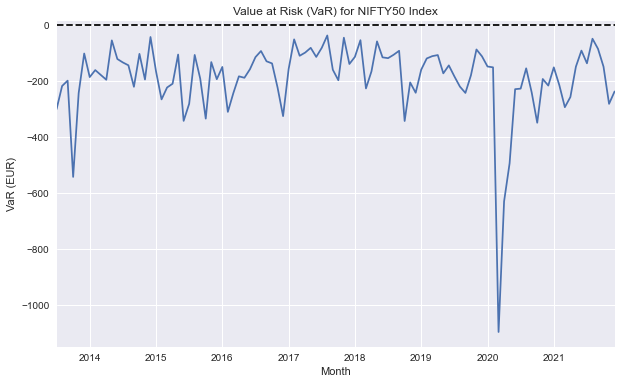

In [18]:
import matplotlib.pyplot as plt

# Set plot style
plt.style.use('seaborn')

# Plot VaR results for IT40 index
var_df['NIFTY50'].plot(kind='line', figsize=(10, 6))

# Set plot title and axis labels
plt.title('Value at Risk (VaR) for NIFTY50 Index')
plt.xlabel('Month')
plt.ylabel('VaR (EUR)')

# Add horizontal line for zero VaR
plt.axhline(y=0, color='black', linestyle='--')

# Show plot
plt.show()